In [1]:
!pip install keras-tuner

import os
import sys
import warnings

# Suprime warnings do TensorFlow e CUDA
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

# Redireciona stderr do C++ para /dev/null temporariamente
devnull = open(os.devnull, 'w')
old_stderr = os.dup(2)
os.dup2(devnull.fileno(), 2)

warnings.filterwarnings('ignore')

# Precisa vir ANTES de importar o tensorflow
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)
logging.getLogger('absl').setLevel(logging.ERROR)

import pandas as pd
import numpy as np
import tensorflow as tf

# Suprime também depois de importar
tf.get_logger().setLevel('ERROR')
tf.autograph.set_verbosity(0)

# Restaura stderr após o TF inicializar
os.dup2(old_stderr, 2)
os.close(old_stderr)
devnull.close()

from tensorflow.keras import layers, models, Input, ops
import keras_tuner as kt
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder


[notice] A new release of pip is available: 25.2 -> 26.0.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [2]:
df = pd.read_csv('../data/processed/biometria_final.csv')
y = LabelEncoder().fit_transform(df['cow_id'])

def create_pairs(X, y):
    pairs, labels = [], []
    class_indices = {c: np.where(y == c)[0] for c in np.unique(y)}
    for i in range(len(X)):
        # Par Positivo
        idx_pos = np.random.choice(class_indices[y[i]])
        pairs += [[X[i], X[idx_pos]]]
        labels += [1]
        # Par Negativo
        neg_class = np.random.choice([c for c in class_indices if c != y[i]])
        idx_neg = np.random.choice(class_indices[neg_class])
        pairs += [[X[i], X[idx_neg]]]
        labels += [0]
    return np.array(pairs), np.array(labels).astype('float32')

In [3]:
def build_model(hp, input_dim):
    # Parametrização da Camada de Extração de Identidade (Embedding)
    hp_units = hp.Int('units', 256, 1024, step=128)
    hp_embed = hp.Int('embed_dim', 64, 256, step=64)
    
    input_branch = Input(shape=(input_dim,))
    x = layers.Dense(hp_units, activation='relu')(input_branch)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(hp.Float('dropout', 0.2, 0.5, step=0.1))(x)
    x = layers.Dense(hp_units // 2, activation='relu')(x)
    embed_out = layers.Dense(hp_embed, activation='relu')(x)
    branch_model = models.Model(input_branch, embed_out)

    # Lógica de Comparação
    in_l, in_r = Input(shape=(input_dim,)), Input(shape=(input_dim,))
    diff = ops.abs(branch_model(in_l) - branch_model(in_r))
    output = layers.Dense(1, activation='sigmoid')(diff)

    model = models.Model(inputs=[in_l, in_r], outputs=output)
    model.compile(optimizer=tf.keras.optimizers.Adam(hp.Float('lr', 1e-4, 1e-2, sampling='log')),
                  loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [4]:
import contextlib

@contextlib.contextmanager
def suppress_stderr():
    devnull = open(os.devnull, 'w')
    old_stderr = os.dup(2)
    os.dup2(devnull.fileno(), 2)
    try:
        yield
    finally:
        os.dup2(old_stderr, 2)
        os.close(old_stderr)
        devnull.close()

cols_geo = [c for c in df.columns if c.startswith('geo_')]
cols_img_struct = [c for c in df.columns if 'img_hog_' in c or 'img_lbp_' in c]

cenarios = {
    "Geometria Pura": cols_geo,
    "Independente de Cor (HOG+LBP+Geo)": cols_geo + cols_img_struct
}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for nome, cols in cenarios.items():
    print(f"\n🚀 Tunando Siamesas para: {nome}")
    X_data = df[cols].values
    fold_accs = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(X_data, y)):
        scaler = StandardScaler()
        X_train_fold = scaler.fit_transform(X_data[train_idx])
        X_val_fold = scaler.transform(X_data[val_idx])

        X_tr_p, y_tr_p = create_pairs(X_train_fold, y[train_idx])
        X_vl_p, y_vl_p = create_pairs(X_val_fold, y[val_idx])

        tuner = kt.BayesianOptimization(
            lambda hp: build_model(hp, X_train_fold.shape[1]),
            objective='val_accuracy', max_trials=15,
            directory='tuner_logs', project_name=f'siamese_{nome[:3]}_f{fold}', overwrite=True
        )

        with suppress_stderr():
            tuner.search([X_tr_p[:,0], X_tr_p[:,1]], y_tr_p,
                         validation_data=([X_vl_p[:,0], X_vl_p[:,1]], y_vl_p),
                         epochs=30, batch_size=16, verbose=0)

        best_model = tuner.get_best_models(num_models=1)[0]
        _, acc = best_model.evaluate([X_vl_p[:,0], X_vl_p[:,1]], y_vl_p, verbose=0)
        fold_accs.append(acc)
        print(f"✅ Fold {fold+1}: {acc:.2%}")

    print(f"📊 MÉDIA FINAL {nome}: {np.mean(fold_accs):.2%}")


🚀 Tunando Siamesas para: Geometria Pura
✅ Fold 1: 58.50%
✅ Fold 2: 63.67%
✅ Fold 3: 61.50%
✅ Fold 4: 62.67%
✅ Fold 5: 62.67%
📊 MÉDIA FINAL Geometria Pura: 61.80%

🚀 Tunando Siamesas para: Independente de Cor (HOG+LBP+Geo)
✅ Fold 1: 91.67%
✅ Fold 2: 92.00%
✅ Fold 3: 91.50%
✅ Fold 4: 91.33%
✅ Fold 5: 91.67%
📊 MÉDIA FINAL Independente de Cor (HOG+LBP+Geo): 91.63%


19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step


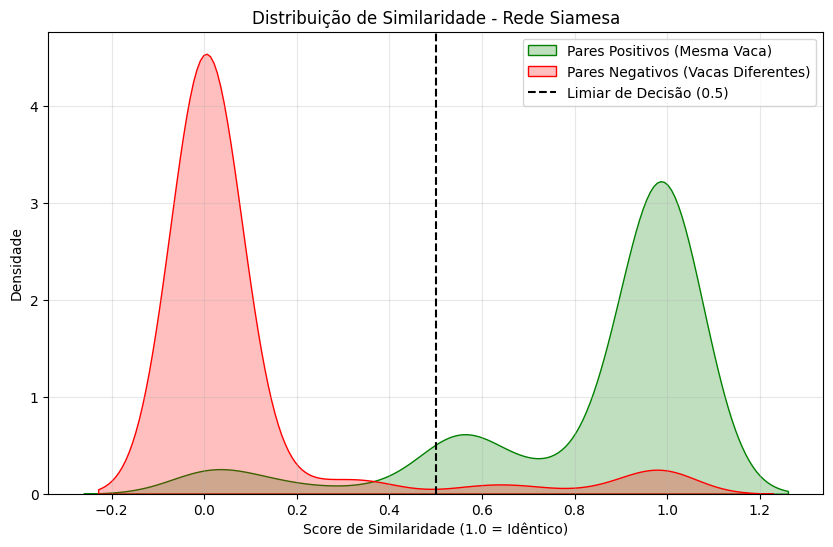

Média de similaridade para pares positivos: 0.8425
Média de similaridade para pares negativos: 0.0827


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Função para extrair distâncias do conjunto de teste do último fold
y_val_pred = best_model.predict([X_vl_p[:,0], X_vl_p[:,1]])

# Separar distâncias de pares positivos e negativos
dist_positivos = y_val_pred[y_vl_p == 1]
dist_negativos = y_val_pred[y_vl_p == 0]

plt.figure(figsize=(10, 6))
sns.kdeplot(dist_positivos.flatten(), label='Pares Positivos (Mesma Vaca)', fill=True, color='green')
sns.kdeplot(dist_negativos.flatten(), label='Pares Negativos (Vacas Diferentes)', fill=True, color='red')

plt.axvline(x=0.5, color='black', linestyle='--', label='Limiar de Decisão (0.5)')
plt.title('Distribuição de Similaridade - Rede Siamesa')
plt.xlabel('Score de Similaridade (1.0 = Idêntico)')
plt.ylabel('Densidade')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

print(f"Média de similaridade para pares positivos: {np.mean(dist_positivos):.4f}")
print(f"Média de similaridade para pares negativos: {np.mean(dist_negativos):.4f}")